In [30]:


import pandas as pd
import numpy as np
import shap
import seaborn as sns

from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import silhouette_score, davies_bouldin_score

from xgboost import XGBRegressor

from utils.visualization import (visualize_box_plot, visualize_distribution, visualize_k_neighbors_distance, visualize_variance_PCA)
from utils.pipeline import create_pipeline
from utils.util import (
    undump_ZV, get_cols_containing, get_columns_by_type, feature_importances_to_df, get_feature_to_keep,
    reduce_features, measure_performace, load_data, get_outlies_DBSCAN, search_params_DBSCAN
)
from utils.outliers import (
    count_values_above_percentile, count_values_below, remove_outliers, fix_logical_errors, count_values_above
    )
from utils.feature_engineering import (
    apply_feature_engineering
)
from utils.constants import (
    target_column, DATA_PATH, DATA_FILE_NAME, MACRO_FILE_NAME,
    categorical_columns
)

# Кластеры для районов
# Таргет трайнуть

In [31]:
pd.options.display.float_format = '{:.6f}'.format
pd.set_option('display.max_rows', None)  # Show all rows
pd.set_option('display.max_columns', None)  # Show all columns if needed
np.set_printoptions(threshold=np.inf)  # For NumPy arrays

In [32]:
# def normalize_array(scores):
#     scores = np.array(scores)  # Ensure input is a numpy array
#     total = np.sum(scores)     # Compute the sum of the array
#     if total == 0:
#         raise ValueError("Sum of scores is zero. Cannot normalize.")
#     return scores / total      # Normalize by dividing each element by the total


# normalize_array([0.099535, 0.010609, 0.007780, 0.007170, 0.003508, 0.002087])

In [33]:
raw_data_df, raw_macro_df = load_data(DATA_PATH, [DATA_FILE_NAME, MACRO_FILE_NAME])

In [34]:
# print(raw_macro_df.info())

In [35]:
# raw_data_df.head(1)

In [36]:
# raw_macro_df.head()

In [ ]:
columns_to_clean = ['child_on_acc_pre_school', 'modern_education_share', 'old_education_build_share']

for col in columns_to_clean:
    raw_macro_df[col] = (
        raw_macro_df[col]
        .replace('#!', None)                 # Replace '#!' with None (Python's native missing value)
        .str.replace(',', '.', regex=True)  # Replace commas with periods for decimal handling
        .astype(float)                      # Convert to numeric, None is treated as NaN
    )

macro_most_important_features = ['timestamp'] + [
    'cpi', 'micex_rgbi_tr', 'rent_price_3room_bus', 'rent_price_4+room_bus', 'rts', 'ppi', 'rent_price_2room_bus',
    'mortgage_value', 'deposits_rate', 'mortgage_rate', 'usdrub', 'balance_trade', 'oil_urals', 'brent', 'gdp_quart_growth',
    'average_provision_of_build_contract_moscow', 'net_capital_export', 'rent_price_1room_bus', 'grp',
    'average_provision_of_build_contract', 'deposits_growth', 'income_per_cap', 'micex', 'balance_trade_growth', 'eurrub',
    'rent_price_2room_eco', 'rent_price_1room_eco', 'gdp_quart', 'mortgage_growth', 'micex_cbi_tr',
    'real_dispos_income_per_cap_growth', 'grp_growth'
]
raw_macro_df = raw_macro_df[macro_most_important_features]
    

time_span_col_name = 'month'
period = 'M'

# time_span_col_name = 'quarter'
# period = 'Q'

# time_span_col_name = 'year'
# period = 'Y'

# Step 1: Prepare transactions dataset
transactions = raw_data_df.copy()
transactions[time_span_col_name] = transactions['timestamp'].dt.to_period(period)

# Separate columns for different aggregation metrics
sum_columns = ['mortgage_value', 'other_sum_based_column']
median_columns = [col for col in raw_macro_df.columns if col not in sum_columns + ['timestamp', 'month']]

# Perform aggregation
macro_aggregated = raw_macro_df.groupby(raw_macro_df[time_span_col_name]).agg({**{col: 'sum' for col in sum_columns},
                                                      **{col: 'median' for col in median_columns}})


raw_macro_df[time_span_col_name] = raw_macro_df['timestamp'].dt.to_period(period)
macro_per_period = raw_macro_df.groupby(raw_macro_df[time_span_col_name]).mean()
macro_per_period = macro_per_period.drop(columns=['timestamp'])

# Step 3: Merge transactions with aggregated macro data
transactions_with_macro = pd.merge(
    transactions,
    macro_per_period,
    how='left',
    left_on=time_span_col_name,
    right_on=time_span_col_name
)

In [75]:
transactions_with_macro.loc[transactions_with_macro['rent_price_2room_eco'] < 37.5, 'rent_price_2room_eco'] = np.nan
transactions_with_macro.loc[transactions_with_macro['rent_price_1room_eco'] < 30, 'rent_price_1room_eco'] = np.nan
transactions_with_macro.loc[transactions_with_macro['rent_price_3room_bus'] > 115, 'rent_price_3room_bus'] = np.nan
transactions_with_macro.loc[transactions_with_macro['rent_price_4+room_bus'] < 130, 'rent_price_4+room_bus'] = np.nan
print(transactions_with_macro['mortgage_value'].mean())
print(transactions_with_macro['mortgage_growth'].describe())


681159.0196252174
count   30471.000000
mean        0.366760
std         0.273597
min        -0.408860
25%         0.294960
50%         0.358752
75%         0.500617
max         1.051914
Name: mortgage_growth, dtype: float64


0
Col_name: mortgage_growth
Number of rows < 50: 30471


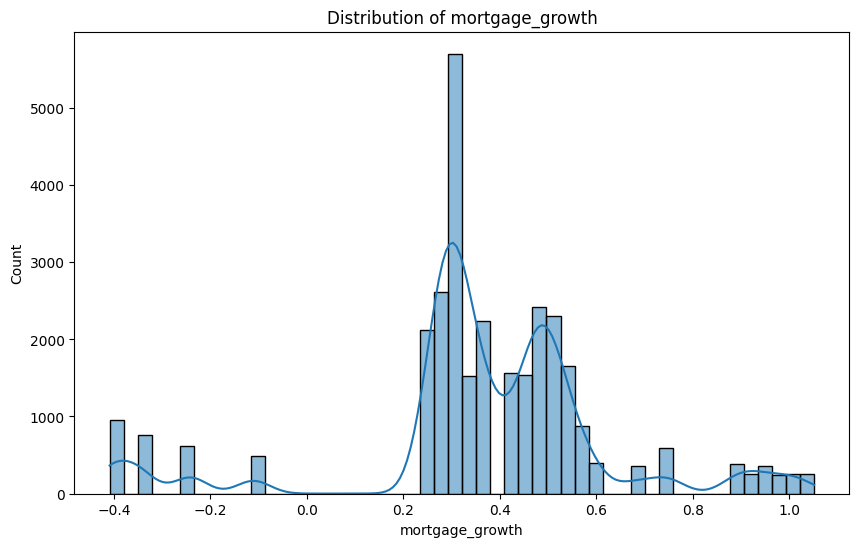

In [74]:
col_to_visualize = 'mortgage_growth'
data_to_visualize = transactions_with_macro
# data_to_visualize = raw_macro_df

print(sum(data_to_visualize[col_to_visualize].isna()))
# count_values_above(data_to_visualize, col_to_visualize, 115)
count_values_below(data_to_visualize, col_to_visualize, 50)

visualize_distribution(data_to_visualize[col_to_visualize], col_to_visualize)

In [11]:
raw_data_df = transactions_with_macro
raw_data_df = fix_logical_errors(raw_data_df)
outliers_removed_df = remove_outliers(raw_data_df)
# outliers_removed_df = raw_data_df

price_doc: 3264 rows
full_sq: 636 rows
Original data size: 30471 rows
Filtered data size: 26571 rows


In [12]:
distances = [500, 1000, 1500, 2000, 3000, 5000]

for distance in distances:
    print(f'office_sqm_{distance}', (raw_data_df[f'office_sqm_{distance}'] > raw_data_df[f'area_m']).sum())
    print(f'trc_sqm_{distance}', (raw_data_df[f'trc_sqm_{distance}'] > raw_data_df[f'area_m']).sum())
    
# print((raw_data_df['children_preschool'] > raw_data_df['full_all']).sum())


raw_data_df[raw_data_df['children_preschool'] > raw_data_df['full_all']].head(5)

office_sqm_500 0
trc_sqm_500 0
office_sqm_1000 0
trc_sqm_1000 0
office_sqm_1500 0
trc_sqm_1500 0
office_sqm_2000 0
trc_sqm_2000 0
office_sqm_3000 122
trc_sqm_3000 0
office_sqm_5000 1732
trc_sqm_5000 53


,id,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,product_type,sub_area,area_m,raion_popul,green_zone_part,indust_part,children_preschool,preschool_quota,preschool_education_centers_raion,children_school,school_quota,school_education_centers_raion,school_education_centers_top_20_raion,hospital_beds_raion,healthcare_centers_raion,university_top_20_raion,sport_objects_raion,additional_education_raion,culture_objects_top_25,culture_objects_top_25_raion,shopping_centers_raion,office_raion,thermal_power_plant_raion,incineration_raion,oil_chemistry_raion,radiation_raion,railroad_terminal_raion,big_market_raion,nuclear_reactor_raion,detention_facility_raion,full_all,male_f,female_f,young_all,young_male,young_female,work_all,work_male,work_female,ekder_all,ekder_male,ekder_female,0_6_all,0_6_male,0_6_female,7_14_all,7_14_male,7_14_female,0_17_all,0_17_male,0_17_female,16_29_all,16_29_male,16_29_female,0_13_all,0_13_male,0_13_female,raion_build_count_with_material_info,build_count_block,build_count_wood,build_count_frame,build_count_brick,build_count_monolith,build_count_panel,build_count_foam,build_count_slag,build_count_mix,raion_build_count_with_builddate_info,build_count_before_1920,build_count_1921-1945,build_count_1946-1970,build_count_1971-1995,build_count_after_1995,ID_metro,metro_min_avto,metro_km_avto,metro_min_walk,metro_km_walk,kindergarten_km,school_km,park_km,green_zone_km,industrial_km,water_treatment_km,cemetery_km,incineration_km,railroad_station_walk_km,railroad_station_walk_min,ID_railroad_station_walk,railroad_station_avto_km,railroad_station_avto_min,ID_railroad_station_avto,public_transport_station_km,public_transport_station_min_walk,water_km,water_1line,mkad_km,ttk_km,sadovoe_km,bulvar_ring_km,kremlin_km,big_road1_km,ID_big_road1,big_road1_1line,big_road2_km,ID_big_road2,railroad_km,railroad_1line,zd_vokzaly_avto_km,ID_railroad_terminal,bus_terminal_avto_km,ID_bus_terminal,oil_chemistry_km,nuclear_reactor_km,radiation_km,power_transmission_line_km,thermal_power_plant_km,ts_km,big_market_km,market_shop_km,fitness_km,swim_pool_km,ice_rink_km,stadium_km,basketball_km,hospice_morgue_km,detention_facility_km,public_healthcare_km,university_km,workplaces_km,shopping_centers_km,office_km,additional_education_km,preschool_km,big_church_km,church_synagogue_km,mosque_km,theater_km,museum_km,exhibition_km,catering_km,ecology,green_part_500,prom_part_500,office_count_500,office_sqm_500,trc_count_500,trc_sqm_500,cafe_count_500,cafe_sum_500_min_price_avg,cafe_sum_500_max_price_avg,cafe_avg_price_500,cafe_count_500_na_price,cafe_count_500_price_500,cafe_count_500_price_1000,cafe_count_500_price_1500,cafe_count_500_price_2500,cafe_count_500_price_4000,cafe_count_500_price_high,big_church_count_500,church_count_500,mosque_count_500,leisure_count_500,sport_count_500,market_count_500,green_part_1000,prom_part_1000,office_count_1000,office_sqm_1000,trc_count_1000,trc_sqm_1000,cafe_count_1000,cafe_sum_1000_min_price_avg,cafe_sum_1000_max_price_avg,cafe_avg_price_1000,cafe_count_1000_na_price,cafe_count_1000_price_500,cafe_count_1000_price_1000,cafe_count_1000_price_1500,cafe_count_1000_price_2500,cafe_count_1000_price_4000,cafe_count_1000_price_high,big_church_count_1000,church_count_1000,mosque_count_1000,leisure_count_1000,sport_count_1000,market_count_1000,green_part_1500,prom_part_1500,office_count_1500,office_sqm_1500,trc_count_1500,trc_sqm_1500,cafe_count_1500,cafe_sum_1500_min_price_avg,cafe_sum_1500_max_price_avg,cafe_avg_price_1500,cafe_count_1500_na_price,cafe_count_1500_price_500,cafe_count_1500_price_1000,cafe_count_1500_price_1500,cafe_count_1500_price_2500,cafe_count_1500_price_4000,cafe_count_1500_price_high,big_church_count_1500,church_count_1500,mosque_count_1500,leisure_count_1500,sport_count_1500,market_count_1500,green_part_2000,prom_part_2000,office_count_2000,office_sqm_2000,trc_count_2000,trc_sqm_2000,cafe_count_2000,cafe_sum_2000_min_price_avg,cafe_sum_2000_max_price_av

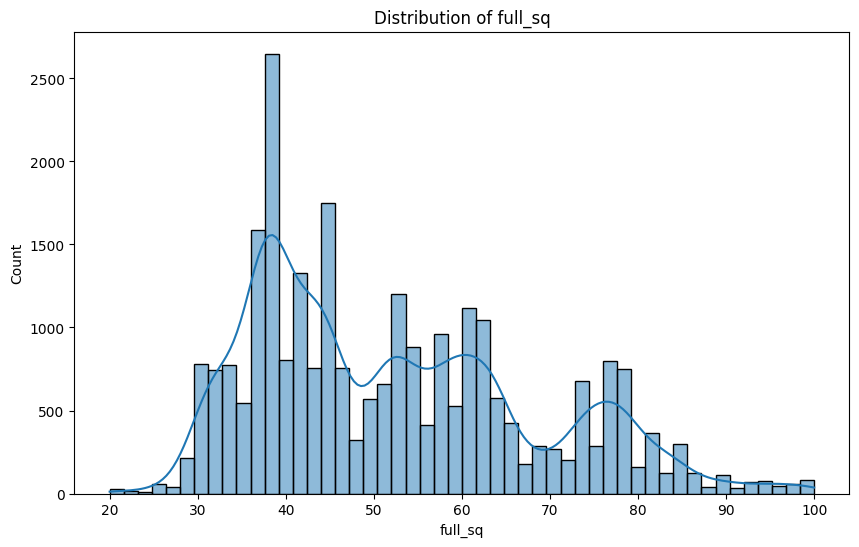

Col_name: full_sq
Skewness: 0.6536545826000808
Upper_bound: 93.29999999999927
Dataset total rows: 26571
Number of rows > 93.29999999999927: 266
Number of NaN: 0


In [13]:
col_to_visualize = 'full_sq'
data_to_visualize = raw_data_df
data_to_visualize = outliers_removed_df

# count_values_above(data_to_visualize, col_to_visualize, 200)
# count_values_below(data_to_visualize, col_to_visualize, 20)

visualize_distribution(data_to_visualize[col_to_visualize], col_to_visualize)
# visualize_box_plot(data_to_visualize[col_to_visualize], col_to_visualize)
count_values_above_percentile(data_to_visualize, col_name=col_to_visualize)

In [14]:
# data = Data_train
raw_data_df = outliers_removed_df
raw_data_df = raw_data_df.drop(columns=['id'])

X = raw_data_df.drop(columns=[target_column])
y = raw_data_df[target_column]

In [15]:
X = apply_feature_engineering(X, y)

In [16]:
numerical_columns, _ = get_columns_by_type(X)
all_columns = categorical_columns + numerical_columns

In [17]:
preprocessing_pipeline = create_pipeline(
    all_columns=all_columns,
    numerical_columns=numerical_columns,
    include_scaling=False,
    include_knn_imputation=False,
    include_ecology_imputation=False
)

X_processed = preprocessing_pipeline.fit_transform(X, y)

In [18]:
# from utils.util import dump_ZV


# preprocessing_pipeline = create_pipeline(
#     all_columns=all_columns,
#     numerical_columns=numerical_columns,
#     include_scaling=True,
#     include_knn_imputation=True,
#     include_ecology_imputation=True
# )

# processed_pipeline = preprocessing_pipeline.fit(X, y)
# X_scaled = processed_pipeline.transform(X)
# dump_ZV(X_scaled, 'X_scaled_for_DBSCAN_fi_custom_outliers_price_3_20_sq_20_100_logic_fix_2')

In [19]:
# # Cell 1: Load and Combine Data
# X_scaled = undump_ZV('X_scaled_for_DBSCAN_fi_custom_outliers_price_3_20_sq_20_100_logic_fix_2')

# # Prepare the original dataset
# X_copy = X.copy()  # Create a copy of the original features
# if 'price_doc' not in X.columns:
#     X_copy['price_doc'] = y 

# # Scale the target independently
# target_scaler = StandardScaler()
# price_doc_scaled = target_scaler.fit_transform(y.values.reshape(-1, 1))

# # Combine scaled features and target
# X_scaled_combined = np.hstack([X_scaled, price_doc_scaled])



# # Cell 2: PCA Dimensionality Reduction
# n_components = 44
# # n_components = 35
# pca = PCA(n_components=n_components, random_state=42)
# X_pca = pca.fit_transform(X_scaled_combined)



# eps = 10  # Adjust based on k-Distance Plot elbow
# k = 90  # Use the same value as min_samples
# # visualize_variance_PCA(pca, target_variance = 0.90)
# # visualize_k_neighbors_distance(X_pca, k)
# labels, outlier_indices = get_outlies_DBSCAN(X_pca, eps, min_samples=k, measure_scores=True)

# outliers_original = X_copy.iloc[outlier_indices]  # Map outliers to the original dataset

# X_processed = np.delete(X_processed, outlier_indices, axis=0)  # Drop outlier rows
# y = np.delete(y, outlier_indices, axis=0)  # Drop the same rows in target
# len(X_processed)

In [20]:
# Define ranges for eps and min_samples
# eps_values = [3, 4]  # Adjust based on k-Distance Plot
# min_samples_values = [25, 30, 35, 40]  # Based on dimensionality and domain knowledge
# results_df = search_params_DBSCAN(X_pca, eps_values, min_samples_values)
# results_df


In [21]:
# plt.figure(figsize=(10, 6))
# plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='viridis', s=10)
# plt.colorbar()
# plt.title("DBSCAN Clustering")
# plt.show()


In [22]:
# outlier_mask = (labels == -1)
# plt.figure(figsize=(10, 6))
# plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='viridis', s=10, label="Clusters")
# plt.scatter(X_pca[outlier_mask, 0], X_pca[outlier_mask, 1], c='red', s=10, label="Outliers")
# plt.colorbar(label="Cluster Labels")
# plt.legend()
# plt.title("DBSCAN Clustering with Outliers Highlighted")
# plt.show()


In [23]:
# # Cell 6: Print Outliers Information
# top_20_features = [
#     'price_doc', 'full_sq', 'life_sq', 'floor', 'max_floor', 'build_year', 'num_room', 
#     'kitch_sq', 'state', 'kremlin_km', 'metro_km_walk', 'park_km', 'school_km', 
#     'kindergarten_km', 'shopping_centers_km', 'green_zone_km', 'railroad_station_walk_km', 
#     'industrial_km', 'cafe_count_500', 'market_count_500'
# ]

# # Analyze outliers with selected features
# outliers_top_features = outliers_original[top_20_features]

# print(f"Outliers detected: {len(outlier_indices)}")
# print("Sample Outliers in Original Dataset (Top 20 Features):")
# outliers_top_features.head(1)

In [24]:
# # Cell 7: Visualize Outliers in Original Features
# plt.figure(figsize=(10, 6))
# plt.scatter(X_copy['price_doc'], X_copy['full_sq'], c='gray', s=10, label='Normal Points')
# plt.scatter(outliers_original['price_doc'], outliers_original['full_sq'], c='red', s=20, label='Outliers')
# plt.title("Outliers in Original Dataset")
# plt.xlabel("Price (price_doc)")
# plt.ylabel("Size (full_sq)")
# plt.legend()
# plt.grid()
# plt.show()


In [25]:
# reduced_features = ['sub_area', 'weighted_build_count', 'weighted_material_score', 'num_room', 'full_sq', 'life_sq', 'elderly_healthcare_accessibility', 'product_type', 'culture_objects_top_25', 'kitch_sq', 'elderly_dependency_ratio', 'ID_bus_terminal', 'kremlin_km', 'raion_popul', 'ID_big_road1', 'office_raion', 'metro_min_walk', 'raion_build_count_with_material_info']
reduced_features = all_columns

X_reduced, features_reduced = reduce_features(X_processed, all_columns, reduced_features)

Reduced dimensionality: 322 → 322 (Rows: 26571)


In [26]:
X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size=0.2, random_state=42)

In [27]:
model = XGBRegressor(
    n_estimators=100,        # Number of trees
    learning_rate=0.1,       # Step size shrinkage used to prevent overfitting
    max_depth=6,             # Maximum tree depth
    subsample=0.8,           # Subsample ratio of the training instances
    colsample_bytree=0.8,    # Subsample ratio of columns for each split
    random_state=42,
)

# {'colsample_bytree': 0.6, 'learning_rate': 0.05, 'max_depth': 8, 'n_estimators': 150, 'subsample': 0.8}

# model = XGBRegressor(
#     n_estimators=150,        # Number of trees
#     learning_rate=0.05,       # Step size shrinkage used to prevent overfitting
#     max_depth=8,             # Maximum tree depth
#     subsample=0.8,           # Subsample ratio of the training instances
#     colsample_bytree=0.6,    # Subsample ratio of columns for each split
#     random_state=42,
# )


measure_performace(model, X_train, y_train, X_test, y_test)

Exception ignored on calling ctypes callback function: <bound method DataIter._next_wrapper of <xgboost.data.SingleBatchInternalIter object at 0x000002AF1EB2C7A0>>
Traceback (most recent call last):
  File "c:\Users\Nick\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py", line 582, in _next_wrapper
    def _next_wrapper(self, this: None) -> int:  # pylint: disable=unused-argument

KeyboardInterrupt: 


XGBoostError: [13:14:42] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\data\iterative_dmatrix.cc:232: Check failed: accumulated_rows == Info().num_row_ (42512 vs. 21256) : 

In [ ]:
from utils.util import feature_scores_to_df


model_fi = XGBRegressor(
    n_estimators=100,        # Number of trees
    learning_rate=0.1,       # Step size shrinkage used to prevent overfitting
    max_depth=6,             # Maximum tree depth
    subsample=0.8,           # Subsample ratio of the training instances
    colsample_bytree=0.8,    # Subsample ratio of columns for each split
    random_state=42,
)
model_fi.fit(X_train, y_train)
fi_default_df = feature_importances_to_df(features_reduced, model_fi.feature_importances_)
features_to_keep = get_feature_to_keep(fi_default_df, threshold = 0.01)

Keep: 15/322 features
Drop: 307/322 features
Keep list:
 ['sub_area', 'sport_count_3000', 'trc_count_5000', 'life_sq', 'leisure_count_5000', 'num_room', 'cafe_count_3000', 'full_sq', 'cafe_count_5000_price_1500', 'build_count_1921-1945', 'cafe_count_2000', 'raion_build_count_with_material_info', 'cafe_count_3000_price_2500', 'leisure_count_3000', 'build_count_frame']


In [ ]:
weight_score_df = feature_scores_to_df(features_reduced, model_fi, importance_type="weight")
gain_score_df = feature_scores_to_df(features_reduced, model_fi, importance_type="gain")
cover_score_df = feature_scores_to_df(features_reduced, model_fi, importance_type="cover")

macro_score_df = gain_score_df[gain_score_df['Feature'].isin(macro_per_period.columns)]
macro_features_important_df = gain_score_df[gain_score_df['Feature'].isin(macro_per_period.columns)]['Feature'].tolist()

# print(gain_score_df)
print(macro_features_important_df)
print(macro_score_df)

['eurrub', 'usdrub', 'gdp_quart_growth', 'cpi', 'rent_price_3room_bus', 'ppi', 'balance_trade_growth', 'rts', 'average_provision_of_build_contract_moscow', 'micex_rgbi_tr', 'grp', 'rent_price_2room_bus', 'micex_cbi_tr', 'gdp_quart', 'oil_urals', 'brent', 'deposits_growth', 'mortgage_value', 'deposits_rate', 'rent_price_1room_bus', 'mortgage_rate', 'micex', 'rent_price_4+room_bus', 'income_per_cap', 'real_dispos_income_per_cap_growth', 'rent_price_1room_eco', 'grp_growth', 'net_capital_export', 'mortgage_growth', 'rent_price_2room_eco', 'balance_trade', 'average_provision_of_build_contract']
                                         Feature     gain
Rank                                                     
70                                        eurrub 0.003084
72                                        usdrub 0.003003
76                              gdp_quart_growth 0.002804
77                                           cpi 0.002790
80                          rent_price_3room_bus 0.002

In [ ]:
# X_train_df = pd.DataFrame(X_train, columns=reduced_features)
# # Create the SHAP explainer
# explainer = shap.TreeExplainer(model_fi)
# # Compute SHAP values for the dataset
# shap_values = explainer.shap_values(X_train_df)


In [ ]:
# shap.summary_plot(shap_values, X_train_df)
# shap.dependence_plot("sport_count_3000", shap_values, X_train_df)
# shap.initjs()
# shap.force_plot(explainer.expected_value, shap_values[0, :], X_train_df.iloc[0, :])
# shap.summary_plot(shap_values, X_train_df, plot_type="bar")


In [ ]:
# RFE
# SHAP 
# Correlation Analysis
# Mutual Information
# L1 Regularization (LASSO)

# ANOVA F-test: For categorical features.
# Chi-Square Test: For categorical features vs. the target.
# t-tests: For numerical features.

# Boruta: Uses a random forest or XGBoost to iteratively test feature relevance.
# Feature Selector library: Specifically designed for datasets with many features.